# _Churn rate_ o tasa de abandono
Después de un poco de Power volvemos al _machine learning_ para tocar un tema que interesa mucho a los servicios de suscripción, como plataformas de streaming o gimnasios: el _churn rate_ o tasa de abandono. He tomado un conjunto de datos de [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn). Contiene información sobre clientes que abandonaron un servicio de telecomunicaciones en el último mes, así como información sobre la forma en que se inscribieron al servicio, información demográfica y los servicios de los que ha hecho uso el cliente.

## Familiarización con el _dataset_
Veamos a qué nos enfrentamos.

In [1]:
# 1. Cargamos el dataset de churn y vemos las primeras filas y la estructura general.
import pandas as pd

df = pd.read_csv('telco_churn.csv')  # ajusta al nombre real del archivo

print("Primeras filas del dataframe:")
print(df.head())

print("\nInformación general del dataframe:")
print(df.info())

print("\nDistribución de la variable objetivo (Churn):")
print(df['Churn'].value_counts())


Primeras filas del dataframe:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Stream

No hay datos nulos, pero sí muchas columnas.

## Limpieza del _dataset_
Vamos a convertir la columna `Churn` a números, porque los modelos de `sklearn` trabajan mejor con etiquetas 0 y 1. También revisamos el porcentaje de clientes que se van; normalmente hay desbalance, como en este caso. Los vamos a graficar.

In [2]:
# Creamos una nueva columna binaria para el modelo.
df['churn_flag'] = df['Churn'].map({'No': 0, 'Yes': 1})

print("Distribución de churn_flag (0 = se queda, 1 = se va):")
print(df['churn_flag'].value_counts(normalize=True))


Distribución de churn_flag (0 = se queda, 1 = se va):
churn_flag
0    0.73463
1    0.26537
Name: proportion, dtype: float64


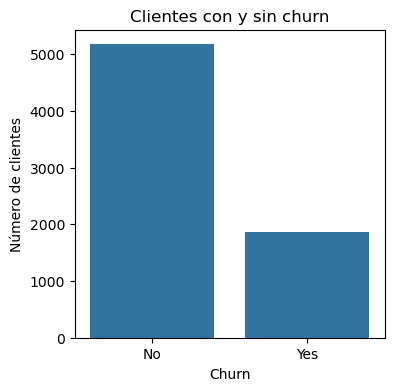

In [3]:
# 3. Visualizamos cuántos clientes se quedan y cuántos se van.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.countplot(data=df, x='Churn')
plt.title('Clientes con y sin churn')
plt.xlabel('Churn')
plt.ylabel('Número de clientes')
plt.show()

Ya que hemos visualizado el desbalance, veamos si el abandono por tipo de contrato varía demasiado.

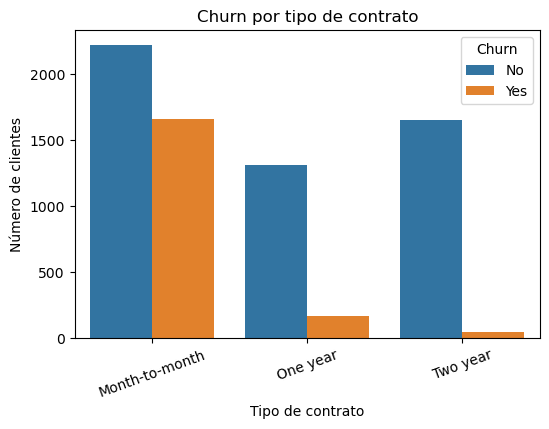

In [4]:
# 4. Ejemplo: comparamos churn según el tipo de contrato.
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn por tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Número de clientes')
plt.xticks(rotation=20)
plt.legend(title='Churn')
plt.show()


Como era de pensarse, los usuarios con contratos mensuales son más propensos a abandonar que los usuarios con contratos de un año a dos años.

## Preparación de las variables del modelo
Vamos a deshacernos de los identificadores de usuario, pues no aportan información revelante al modelo.

In [5]:
# 5. Creamos el dataframe que usaremos para el modelo:
df_model = df.drop(['customerID', 'Churn'], axis=1)

print("Columnas que usaremos en el modelo:")
print(df_model.columns)


Columnas que usaremos en el modelo:
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'churn_flag'],
      dtype='object')


Además aplicaremos `get_dummies` para convertir textos como 'Male', 'Female', 'Month-to-month', etc., en columnas binarias. Finalmente separamos X (todas las características) y y (la variable `churn_flag`).

In [6]:
# 6. Convertimos las variables categóricas en variables dummies (0/1) para poder usarlas en sklearn.

df_model = pd.get_dummies(df_model, drop_first=True)

# Separamos features (X) y etiqueta (y).
X = df_model.drop('churn_flag', axis=1)
y = df_model['churn_flag']

print("Tamaño de X (features):", X.shape)
print("Tamaño de y (etiquetas):", y.shape)


Tamaño de X (features): (7043, 6559)
Tamaño de y (etiquetas): (7043,)


## División en datos de entrenamiento y prueba

In [7]:
# 7. Dividimos los datos en entrenamiento y prueba de forma estratificada.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      # 30% para prueba
    random_state=42,    # para reproducibilidad
    stratify=y          # mantiene la proporción de churn en train y test
)

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)

Tamaño de X_train: (4930, 6559)
Tamaño de X_test: (2113, 6559)


Nuestro modelo base será de regresión logística.

In [8]:
# 8. Entrenamos un modelo base de Regresión Logística, ajustando pesos por desbalance.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_reg = LogisticRegression(
    class_weight='balanced',  # compensa que haya menos clientes con churn
    max_iter=1000,
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba.
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression - matriz de confusión:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nLogistic Regression - reporte de clasificación:")
print(classification_report(y_test, y_pred_lr, digits=4))


Logistic Regression - matriz de confusión:
[[1174  378]
 [ 129  432]]

Logistic Regression - reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9010    0.7564    0.8224      1552
           1     0.5333    0.7701    0.6302       561

    accuracy                         0.7601      2113
   macro avg     0.7172    0.7632    0.7263      2113
weighted avg     0.8034    0.7601    0.7714      2113



Pero desarrollaremos también un modelo _Random Forest_.

In [9]:
# 9. Entrenamos un Random Forest para capturar relaciones más complejas.
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,              # número de árboles
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'  # ayuda con el desbalance
)

rf.fit(X_train, y_train)

# Predicciones con el Random Forest.
y_pred_rf = rf.predict(X_test)

print("Random Forest - matriz de confusión:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRandom Forest - reporte de clasificación:")
print(classification_report(y_test, y_pred_rf, digits=4))


Random Forest - matriz de confusión:
[[1403  149]
 [ 277  284]]

Random Forest - reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8351    0.9040    0.8682      1552
           1     0.6559    0.5062    0.5714       561

    accuracy                         0.7984      2113
   macro avg     0.7455    0.7051    0.7198      2113
weighted avg     0.7875    0.7984    0.7894      2113



Y a continuación los compararemos:

In [10]:
# 10. Comparamos la capacidad de ranking de ambos modelos con la métrica ROC-AUC.
from sklearn.metrics import roc_auc_score

# Probabilidades de pertenecer a la clase churn (1).
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("ROC-AUC Logistic Regression:", roc_auc_score(y_test, y_proba_lr))
print("ROC-AUC Random Forest:", roc_auc_score(y_test, y_proba_rf))


ROC-AUC Logistic Regression: 0.8447819615193781
ROC-AUC Random Forest: 0.8313739272653767


## Conclusión

Ambos modelos tienen una buena capacidad para ordenar los clientes según su riesgo de abandono, aunque la regresión logística, un modelo más sencillo, se ha desempeñado un poco mejor. Esto sugiere que la relación entre variables no es tan compleja. En situaciones como éstas, el modelo más robusto no siempre es el mejor. Todo depende de la relación entre los datos.